# Propósito

Este notebook tem como objetivo realizar uma análise exploratória de algumas colunas de interesse das medições dos sensores de qualidade do ar.

O principal objetivo será preencher alguns valores nulos utilizando a função interpolate()

Mas para não enviesar muitos dados preencheremos apenas os valores em que a quantidade de valores nulas no dia semana menor que 7


# Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from scipy.stats import shapiro, anderson, boxcox, kstest, norm
from scipy.special import boxcox1p
from scipy import stats

# Consumindo bases

In [2]:
url_sensor = '/content/drive/MyDrive/TCC/sensores-2011-2021/medicao-sensores.csv'

df_sensor = pd.read_csv(url_sensor, sep=',')

url_estacoes = '/content/drive/MyDrive/TCC/sensores-2011-2021/estacoes.csv'

df_estacoes = pd.read_csv(url_estacoes, sep=',')

In [3]:
df_sensor.columns

Index(['objectid', 'data', 'codnum', 'estação', 'chuva', 'pres', 'rs', 'temp',
       'ur', 'dir_vento', 'vel_vento', 'so2', 'no2', 'hcnm', 'hct', 'ch4',
       'co', 'no', 'nox', 'o3', 'pm10', 'pm2_5', 'lat', 'lon',
       'x_utm_sirgas2000', 'y_utm_sirgas2000'],
      dtype='object')

# Pré-processamento

## Selecionando e criando colunas

In [4]:
#@title Criando coluna nome estacao com base na coluna codnum
df_sensor['nome_estacao'] = df_sensor['codnum'].map(df_estacoes.set_index('codnum')['nome'])

In [5]:
#@title Selecionando as colunas mais relevantes
interest_columns = ['nome_estacao', 'data', 'chuva', 'temp', 'ur', 'co', 'no', 'no2', 'nox', 'so2', 'o3', 'pm10', 'pm2_5']

df_sensor_interest = df_sensor[interest_columns]

In [6]:
#@title Criando colunas de ano e mês para facilitar a análise temporal
df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%Y/%m/%d %H:%M:%S+00')
df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
df_sensor_interest['ano'] = df_sensor_interest['data'].dt.year
df_sensor_interest['mes'] = df_sensor_interest['data'].dt.month

<ipython-input-6-f9a423e0dd73>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data'] = pd.to_datetime(df_sensor_interest['data'], format='%Y/%m/%d %H:%M:%S+00')
<ipython-input-6-f9a423e0dd73>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_interest['data_formatada'] = pd.to_datetime(df_sensor_interest['data']).dt.strftime('%Y-%m-%d')
<ipython-input-6-f9a423e0dd73>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [7]:
#@title Removendo ano de 2011 (Pela falta de alguns poluente) e anos da pandemia
df_sensor_interest_filtered = df_sensor_interest[(df_sensor_interest['ano'] > 2011) & (df_sensor_interest['ano'] < 2020)]

In [8]:
#@title Filtrando por Centro
df_sensor_centro = df_sensor_interest_filtered[df_sensor_interest_filtered['nome_estacao'] == 'ESTAÇÃO CENTRO']

# Tratando colunas de interesse por Estação de monitoriamento


## Estação centro
Colunas normalizadas: Chuva, Temperatura, Umidade relativa, CO, NO, NO2, NOx, SO2, O3, PM10

### Chuva

In [9]:
df_sensor_centro['chuva'].describe()

,chuva
count,68513.000000
mean,0.116626
std,1.026562
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,65.600000


In [10]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_centro[df_sensor_centro['chuva'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 326


In [11]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_centro['chuva_nulos_no_dia'] = (
    df_sensor_centro['chuva'].isnull()
    .groupby(df_sensor_centro['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-11-4d07ebf9ce8e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_centro['chuva_nulos_no_dia'] = (


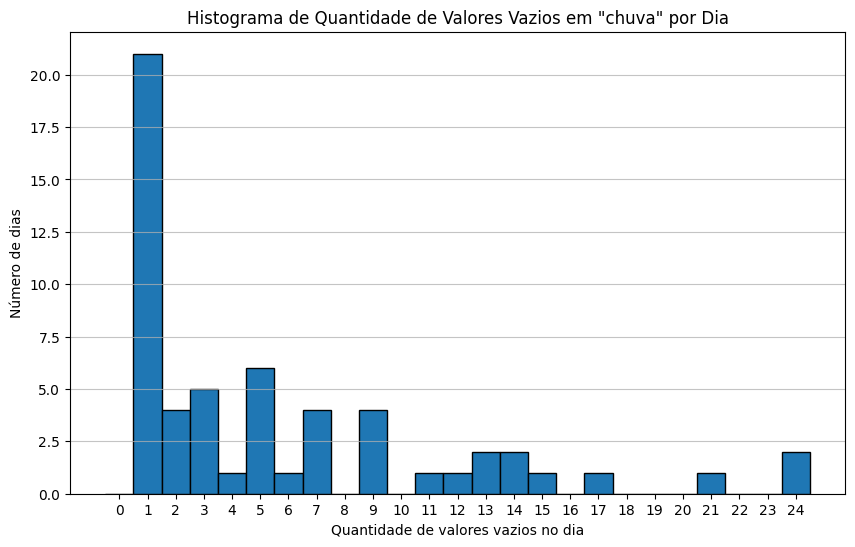

In [12]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_centro[df_sensor_centro['chuva_nulos_no_dia'] != 0].groupby('data_formatada')['chuva_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "chuva" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [13]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias)

mask = (df_sensor_centro['chuva_nulos_no_dia'] <= 6)

num_nulls = df_sensor_centro[mask]['chuva'].isnull().sum()
df_sensor_centro.loc[mask, 'chuva'] = df_sensor_centro[mask]['chuva'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'chuva'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

84 linhas foram preenchidas com interpolate na coluna 'chuva'.
Foram preenchido 26% de dados


In [14]:
df_sensor_centro['chuva'].describe()

,chuva
count,68597.000000
mean,0.116938
std,1.026542
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,65.600000


### Temperatura

In [15]:
df_sensor_centro['temp'].describe()

,temp
count,50437.000000
mean,25.211178
std,4.391686
min,13.530000
25%,22.030000
50%,24.700000
75%,27.870000
max,44.300000


In [16]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_centro[df_sensor_centro['temp'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 18402


In [17]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_centro['temp_nulos_no_dia'] = (
    df_sensor_centro['temp'].isnull()
    .groupby(df_sensor_centro['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-17-7addc1858af5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_centro['temp_nulos_no_dia'] = (


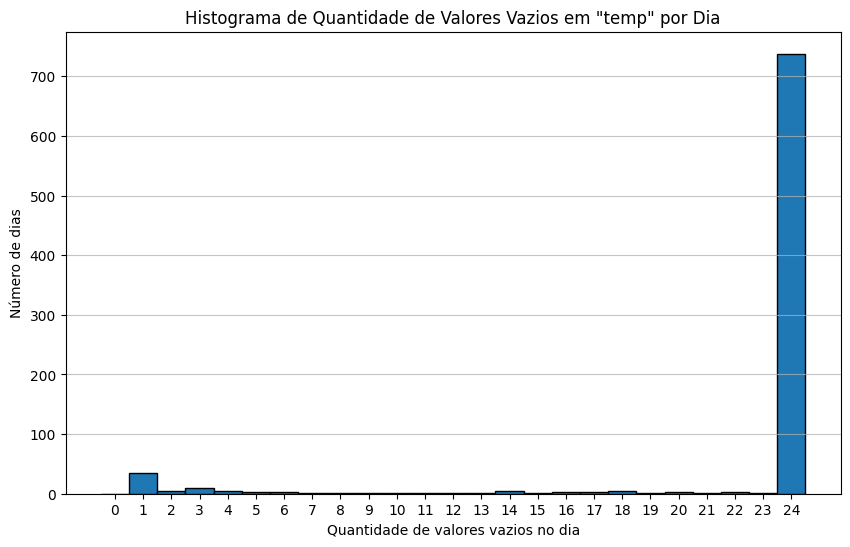

In [18]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_centro[df_sensor_centro['temp_nulos_no_dia'] != 0].groupby('data_formatada')['temp_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "temp" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [19]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_centro['temp_nulos_no_dia'] <= 6)

num_nulls = df_sensor_centro[mask]['temp'].isnull().sum()
df_sensor_centro.loc[mask, 'temp'] = df_sensor_centro[mask]['temp'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'temp'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

119 linhas foram preenchidas com interpolate na coluna 'temp'.
Foram preenchido 1% de dados


In [20]:
df_sensor_centro['temp'].describe()

,temp
count,50555.000000
mean,25.212777
std,4.391187
min,13.530000
25%,22.030000
50%,24.700000
75%,27.870000
max,44.300000


### Umidade relativa

In [21]:
df_sensor_centro['ur'].describe()

,ur
count,50068.000000
mean,68.708696
std,16.244417
min,0.000000
25%,57.780000
50%,70.980000
75%,81.230000
max,99.920000


In [22]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_centro[df_sensor_centro['ur'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 18771


In [23]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_centro['ur_nulos_no_dia'] = (
    df_sensor_centro['ur'].isnull()
    .groupby(df_sensor_centro['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-23-560500e07d72>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_centro['ur_nulos_no_dia'] = (


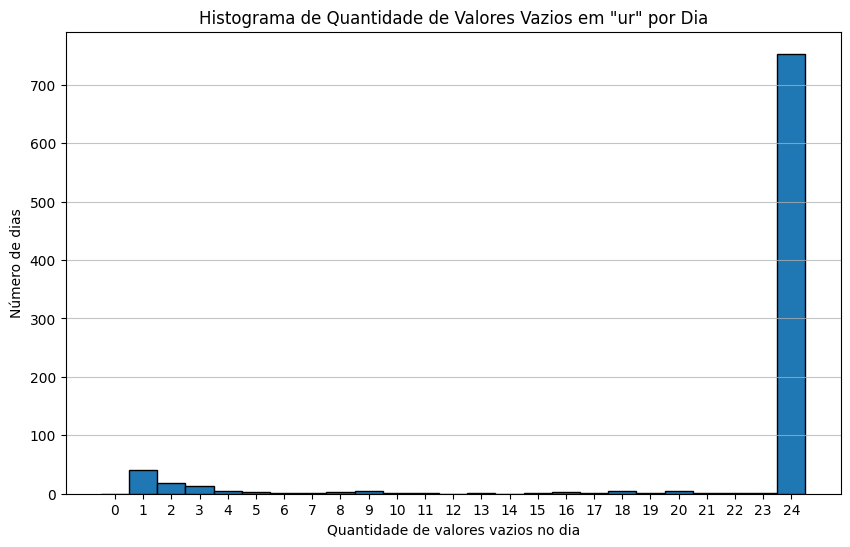

In [24]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_centro[df_sensor_centro['ur_nulos_no_dia'] != 0].groupby('data_formatada')['ur_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title('Histograma de Quantidade de Valores Vazios em "ur" por Dia')
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [25]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_centro['ur_nulos_no_dia'] <= 6)

num_nulls = df_sensor_centro[mask]['ur'].isnull().sum()
df_sensor_centro.loc[mask, 'ur'] = df_sensor_centro[mask]['ur'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'ur'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

167 linhas foram preenchidas com interpolate na coluna 'ur'.
Foram preenchido 1% de dados


In [26]:
df_sensor_centro['ur'].describe()

,ur
count,50234.000000
mean,68.726133
std,16.261612
min,0.000000
25%,57.780000
50%,70.980000
75%,81.270000
max,99.920000


### Monóxido de carbono

In [27]:
df_sensor_centro['co'].describe()

,co
count,65388.000000
mean,0.402293
std,0.255648
min,0.000000
25%,0.240000
50%,0.370000
75%,0.520000
max,3.450000


In [28]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_centro[df_sensor_centro['co'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 3451


In [29]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_centro['co_nulos_no_dia'] = (
    df_sensor_centro['co'].isnull()
    .groupby(df_sensor_centro['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-29-d68f9083bda7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_centro['co_nulos_no_dia'] = (


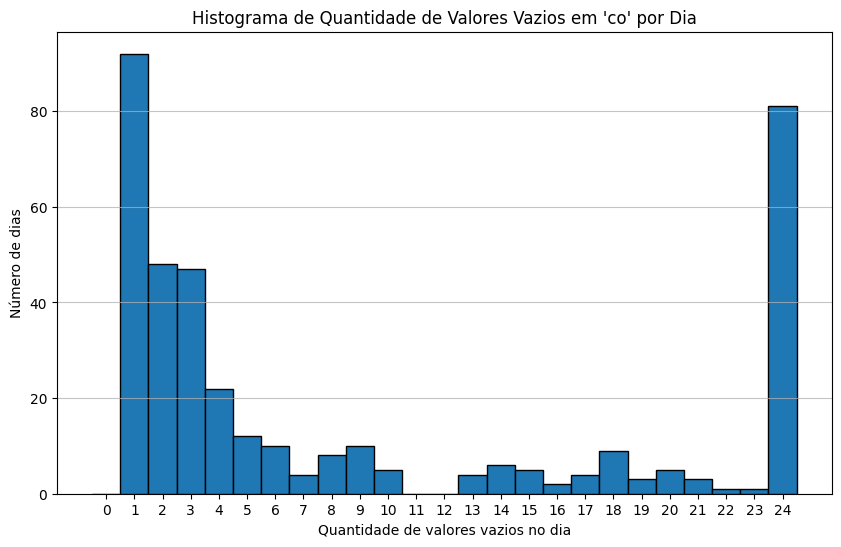

In [30]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_centro[df_sensor_centro['co_nulos_no_dia'] != 0].groupby('data_formatada')['co_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'co' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [31]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_centro['co_nulos_no_dia'] <= 6)

num_nulls = df_sensor_centro[mask]['co'].isnull().sum()
df_sensor_centro.loc[mask, 'co'] = df_sensor_centro[mask]['co'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'co'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

537 linhas foram preenchidas com interpolate na coluna 'co'.
Foram preenchido 16% de dados


In [32]:
df_sensor_centro['co'].describe()

,co
count,65924.000000
mean,0.402913
std,0.255715
min,0.000000
25%,0.240000
50%,0.370000
75%,0.520000
max,3.450000


### Dióxido de Enxofre

In [52]:
df_sensor_centro['so2'].describe()

,so2
count,30699.000000
mean,6.270817
std,7.757769
min,0.000000
25%,1.890000
50%,3.990000
75%,7.590000
max,108.510000


In [34]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_centro[df_sensor_centro['so2'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 39276


In [35]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_centro['so2_nulos_no_dia'] = (
    df_sensor_centro['so2'].isnull()
    .groupby(df_sensor_centro['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-35-ab28031b09d9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_centro['so2_nulos_no_dia'] = (


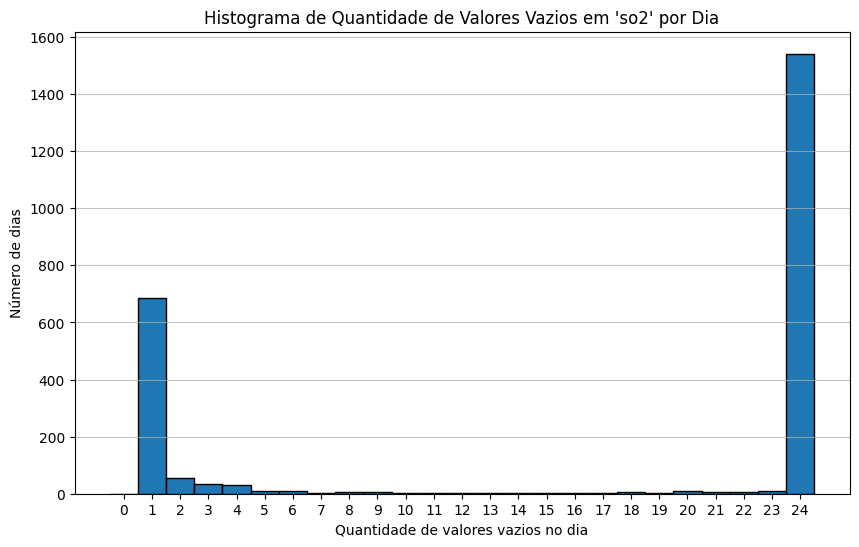

In [36]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_centro[df_sensor_centro['so2_nulos_no_dia'] != 0].groupby('data_formatada')['so2_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'so2' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [37]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_centro['so2_nulos_no_dia'] <= 6)

num_nulls = df_sensor_centro[mask]['so2'].isnull().sum()
df_sensor_centro.loc[mask, 'so2'] = df_sensor_centro[mask]['so2'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'so2'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

1137 linhas foram preenchidas com interpolate na coluna 'so2'.
Foram preenchido 3% de dados


In [38]:
df_sensor_centro['so2'].describe()

,so2
count,30699.000000
mean,6.270817
std,7.757769
min,0.000000
25%,1.890000
50%,3.990000
75%,7.590000
max,108.510000


### Ozônio

In [39]:
df_sensor_centro['o3'].describe()

,o3
count,64787.000000
mean,20.219919
std,21.101212
min,0.000000
25%,4.290000
50%,13.850000
75%,29.630000
max,304.550000


In [40]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_centro[df_sensor_centro['o3'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4052


In [41]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_centro['o3_nulos_no_dia'] = (
    df_sensor_centro['o3'].isnull()
    .groupby(df_sensor_centro['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-41-27e9057cbb15>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_centro['o3_nulos_no_dia'] = (


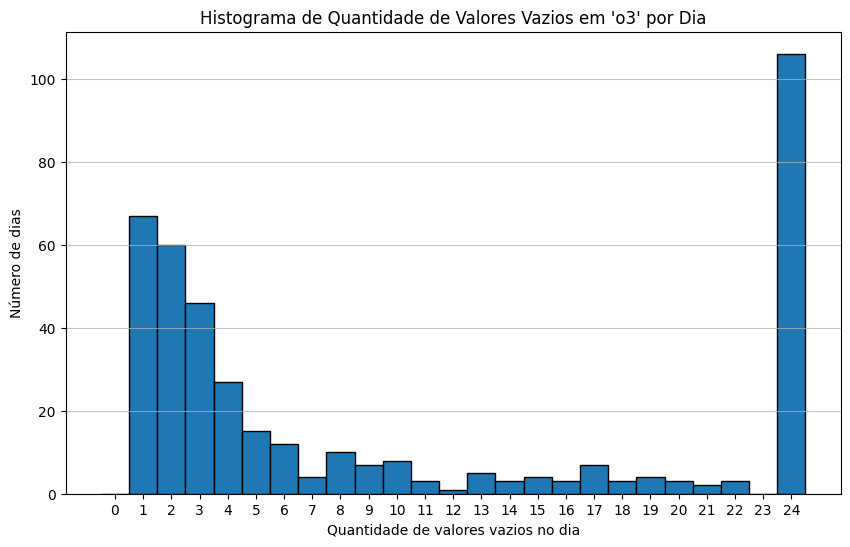

In [42]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_centro[df_sensor_centro['o3_nulos_no_dia'] != 0].groupby('data_formatada')['o3_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'o3' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [43]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_centro['o3_nulos_no_dia'] <= 6)

num_nulls = df_sensor_centro[mask]['o3'].isnull().sum()
df_sensor_centro.loc[mask, 'o3'] = df_sensor_centro[mask]['o3'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'o3'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

580 linhas foram preenchidas com interpolate na coluna 'o3'.
Foram preenchido 14% de dados


In [44]:
df_sensor_centro['o3'].describe()

,o3
count,65366.000000
mean,20.237251
std,21.072022
min,0.000000
25%,4.320000
50%,13.910000
75%,29.650000
max,304.550000


### PM10 Tijuca

In [45]:
df_sensor_centro['pm10'].describe()

,pm10
count,64721.000000
mean,33.089808
std,22.432171
min,0.000000
25%,20.000000
50%,29.000000
75%,42.000000
max,994.000000


In [46]:
#@title Vendo quantidade de valores vazios

valroes_vazio = df_sensor_centro[df_sensor_centro['pm10'].isnull()].groupby(['ano', 'mes']).size().sum()
print(f"Quantidade de valores vazios: {valroes_vazio}")

Quantidade de valores vazios: 4118


In [47]:
#@title Criando coluna que informa a quantidade de valores vazios por dia

df_sensor_centro['pm10_nulos_no_dia'] = (
    df_sensor_centro['pm10'].isnull()
    .groupby(df_sensor_centro['data_formatada'])
    .transform('sum')  # Soma os nulos por dia e repete o valor em todas as linhas do dia
)

<ipython-input-47-63bfe998e37e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_centro['pm10_nulos_no_dia'] = (


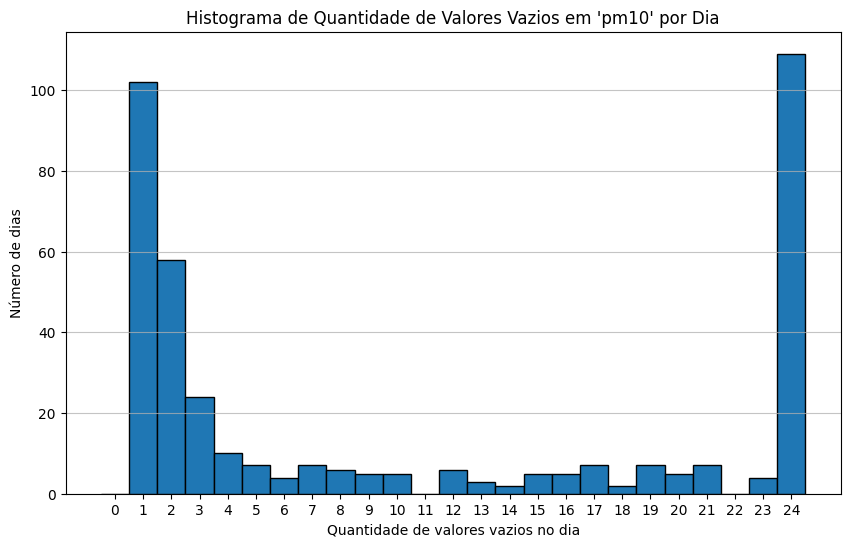

In [48]:
#@title Distribuição dos valores vazios

# Seleciona uma única linha por dia, para evitar repetição
df_dias = df_sensor_centro[df_sensor_centro['pm10_nulos_no_dia'] != 0].groupby('data_formatada')['pm10_nulos_no_dia'].first()

# Plotar o histograma da contagem de valores nulos por dia
plt.figure(figsize=(10,6))
plt.hist(df_dias, bins=range(0, df_dias.max() + 2), edgecolor='black', align='left')
plt.title("Histograma de Quantidade de Valores Vazios em 'pm10' por Dia")
plt.xlabel('Quantidade de valores vazios no dia')
plt.ylabel('Número de dias')
plt.xticks(range(0, df_dias.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [49]:
#@title Preenchimento dos valores nulos utilizando a função interpolate (Preenchendo apenas os que tem menos de 7 linhas vazias por dia)

mask = (df_sensor_centro['pm10_nulos_no_dia'] <= 6)

num_nulls = df_sensor_centro[mask]['pm10'].isnull().sum()
df_sensor_centro.loc[mask, 'pm10'] = df_sensor_centro[mask]['pm10'].interpolate()
print(f"{num_nulls} linhas foram preenchidas com interpolate na coluna 'pm10'.")
print(f"Foram preenchido {round((num_nulls/valroes_vazio)*100)}% de dados")

389 linhas foram preenchidas com interpolate na coluna 'pm10'.
Foram preenchido 9% de dados


In [50]:
df_sensor_centro['pm10'].describe()

,pm10
count,65109.000000
mean,33.100101
std,22.398419
min,0.000000
25%,20.000000
50%,29.000000
75%,42.000000
max,994.000000


# Gerando CSV de saída com a estação de centro preenchida


In [53]:
droping_columns = ['chuva_nulos_no_dia', 'temp_nulos_no_dia', 'ur_nulos_no_dia', 'co_nulos_no_dia', 'so2_nulos_no_dia', 'o3_nulos_no_dia', 'pm10_nulos_no_dia']

df_sensor_centro.drop(columns=droping_columns, inplace=True)

<ipython-input-53-9a601819f353>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sensor_centro.drop(columns=droping_columns, inplace=True)


In [54]:
df_sensor_centro.to_csv('df_sensor_centro_preenchido.csv', index=False)